In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import urllib
import random
import nltk
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

In [412]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [69]:
df_train_raw = pd.read_csv('training_data.csv')
df_train_raw.head(20)

,sor,cdf_seq_no,trans_desc,merchant_cat_code,amt,db_cr_cd,payment_reporting_category,payment_category,is_international,default_brand,default_location,qrated_brand,coalesced_brand,Category
0,HH,T20110701260061756,RECUR DEBIT CRD PMT11/11 DELTA DENTAL OF A11 O...,6300.0,58.34,D,Card,Debit Card,False,DELTA DENTAL OF A11 OF,111-1111111 AR,Delta Dental,Delta Dental,Finance
1,HH,T201302289909010349,"CHECK CRD PURCHASE 11/11 SURETY SOLUTIONS, ...",NaN,103.00,D,Card,Check Card,False,"SURETY SOLUTIONS,",111-111-1111 OR,Surety Solutions,Surety Solutions,Finance
2,HH,T20130726991361190114550,CHECK CRD PURCHASE 11/11 THE COPY STOP ...,NaN,22.44,D,Card,Check Card,False,THE COPY STOP,SALT LAKE CIT UT,The Copy Stop,The Copy Stop,Finance
3,BK,T201207095780929968,MARKET ALERT INC 111-111-1111 TX,7375.0,22.44,NaN,Card,Credit Card,False,MARKET ALERT INC,111-111-1111 TX,Market Alert,Market Alert,Finance
4,HH,T20131230990558080004939,CHECK CRD PURCHASE 11/11 PERT- NER PERFECT ...,NaN,66.25,D,Card,Check Card,False,PERT- NER PERFECT,THE WOODLANDS TX,Hometown Insurance Partners,Hometown Insurance Partners,Finance
5,HH,T20120104320034603,CHECK CRD PURCHASE 11/11 EZEE TITLE LOANS ...,8931.0,37.50,D,Card,Check Card,False,EZEE TITLE LOANS,111-111-1111 AZ,Ezee Title Loans,Ezee Title Loans,Finance
6,HH,T20120105580006666,CHECK CRD PURCHASE 11/11 MIRAGE INSURANCE AGEN...,6300.0,19.00,D,Card,Check Card,False,MIRAGE INSURANCE AGENC,PHOENIX AZ,Mirage Insurance,Mirage Insurance,Finance
7,HH,T201302289919317826,CHECK CRD PURCHASE 11/11 ALLIED CUST FINANC ...,NaN,749.88,D,Card,Check Card,False,ALLIED CUST FINANC,111-111-1111 NJ,Allied Financial,Allied Financial,Finance
8,HH,T201208319928849316,CHECK CRD PURCHASE 11/11 UNIFOUR FINANCIAL ...,NaN,210.63,D,Card,Check Card,False,UNIFOUR FINANCIAL,111-1111111 NC,Unifour Financial Services,Unifour Financial Services,Finance
9,HH,T20110901260005329,CHECK CRD PURCHASE 11/11 CREDIT UNION WEST ...,6012.0,450.00,D,Card,Check Card,False,CREDIT UNION WEST,GLENDALE AZ,Credit Union West Glendale Az,Credit Union West Glendale Az,Finance


In [70]:
def fix_entry(entry, nums=[str(i) for i in range(10)]):
    
    if pd.isnull(entry):
        return entry
    
    entry_list = [e for e in entry.split(' ') if all([n not in e for n in nums]) and e != '']
    
    if not entry_list:
        return pd.NA
    
    return (' '.join(entry_list)).lower()

In [71]:
def remove_ones(entry):
    
    if pd.isnull(entry):
        return entry
    
    entry = ''.join(entry.split('1'))
    entry = ' '.join(entry.split('-'))
    entry = entry.strip(' ')
    
    if entry == '':
        return pd.NA
    
    return entry.lower()

In [72]:
def reduce_df(df_raw):
    
    df_reduced = df_raw[['amt', 'merchant_cat_code', 'default_brand',
                         'coalesced_brand', 'default_location', 'Category']].rename(
                            columns = {
                                    'amt' : 'Amount ($)',
                                    'merchant_cat_code' : 'Merchant Code',
                                    'default_brand' : 'Default Brand',
                                    'coalesced_brand' : 'Coalesced Brand',
                                    'default_location' : 'Location'
                                }
                            )
    
    df_reduced['Merchant Code'] = [pd.NA if pd.isnull(entry) 
                                   else str(int(entry)) if  len(str(int(entry))) == 4
                                   else '0' + str(int(entry))
                                   for entry in df_reduced['Merchant Code']]
    
    for column in ['Default Brand', 'Coalesced Brand', 'Location']:
        df_reduced[column] = [remove_ones(entry) for entry in df_reduced[column].astype('string')]
    
    return df_reduced

df_train_reduced = reduce_df(df_train_raw)

df_train_reduced

,Amount ($),Merchant Code,Default Brand,Coalesced Brand,Location,Category
0,58.34,6300,delta dental of a of,delta dental,ar,Finance
1,103.00,<NA>,"surety solutions,",surety solutions,or,Finance
2,22.44,<NA>,the copy stop,the copy stop,salt lake cit ut,Finance
3,22.44,7375,market alert inc,market alert,tx,Finance
4,66.25,<NA>,pert ner perfect,hometown insurance partners,the woodlands tx,Finance
...,...,...,...,...,...,...
39995,100.00,<NA>,allied fidelity se,fidelity investments,ks,Finance
39996,184.78,<NA>,foremost insurance,foremost insurance,mi,Finance
39997,9.95,7399,"propay usa propay, in",propay,ut,Finance
39998,250.00,6051,cowboy finance llc,cowboy finance,nm,Finance


('5812', 4574)


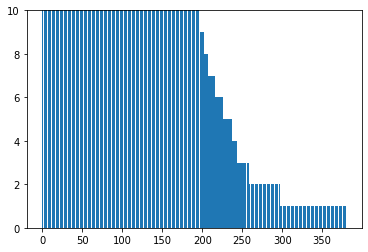

In [113]:
codes = [code for code in list(df_train_reduced['Merchant Code']) if pd.notnull(code)]

codes_dict = {code : 0 for code in sorted(codes)}

for code in codes:
    codes_dict[code] += 1

code_freqs = sorted(list(codes_dict.items()), key=lambda x: -x[1])

print(code_freqs[0])

plt.bar(list(range(len(code_freqs))), ([y for _, y in code_freqs]))
plt.ylim([0,10])
plt.show()

In [144]:
x_train, x_test, y_train, y_test = train_test_split(df_train_reduced['Merchant Code'], df_train_reduced['Category'], test_size=0.025)

def make_pred(code):
    
    default = 'Retail Trade'
    
    if pd.isnull(code):
        return y_train[pd.isnull(x_train)].mode().values[0]
    
    try:
        return y_train[x_train == code].mode().values[0]
    except:
        print('uh oh')
        return default

y_preds = x_test.apply(make_pred)

np.mean(y_preds == y_test)

uh oh
uh oh
uh oh


0.62

In [368]:
df_merchant = pd.read_csv('mcc2.csv')
df_merchant

merchant_dict = {str(code) : fix_entry(desc) for code, desc in zip(df_merchant['Code'], df_merchant['Description'])}

In [369]:
def add_merchant_category(df):
    
    df['Merchant Category'] = [pd.NA if (pd.isnull(entry) or entry not in merchant_dict)
                                             else merchant_dict[entry]
                                             for entry in df['Merchant Code']]
    

    df = df[['Amount ($)', 'Merchant Code', 'Merchant Category',
                'Default Brand', 'Coalesced Brand', 'Location', 'Category']]
    
    return df

df_train_full = add_merchant_category(df_train_reduced)

df_train_full

,Amount ($),Merchant Code,Merchant Category,Default Brand,Coalesced Brand,Location,Category
0,58.34,6300,insurance sales and underwriting,delta dental of a of,delta dental,ar,Finance
1,103.00,<NA>,<NA>,"surety solutions,",surety solutions,or,Finance
2,22.44,<NA>,<NA>,the copy stop,the copy stop,salt lake cit ut,Finance
3,22.44,7375,information retrieval services,market alert inc,market alert,tx,Finance
4,66.25,<NA>,<NA>,pert ner perfect,hometown insurance partners,the woodlands tx,Finance
...,...,...,...,...,...,...,...
39995,100.00,<NA>,<NA>,allied fidelity se,fidelity investments,ks,Finance
39996,184.78,<NA>,<NA>,foremost insurance,foremost insurance,mi,Finance
39997,9.95,7399,business services (nec),"propay usa propay, in",propay,ut,Finance
39998,250.00,6051,quasi cash,cowboy finance llc,cowboy finance,nm,Finance


In [370]:
df_train_full.to_csv('data/training_reduced.csv', index=False)

In [381]:
dclmcat = list(zip(df_train_full['Default Brand'], df_train_full['Coalesced Brand'],
                df_train_full['Location'], df_train_full['Merchant Category'], df_train_full['Category']))

random.shuffle(dclmcat)

for d, c, l, m, cat in dclmcat[:3]:
    
    search_dict = search_full(d, c, l)
    
    final_list = []
    for entry in search_dict['co'] + search_dict['def']:
        if pd.notnull(entry) and entry not in final_list:
            final_list.append(entry)
    
    desc = 'None' if not final_list else '; '.join(final_list)
    
    print('Brand 1: ', c, '.', sep='')
    print('Brand 2: ', d, '.', sep='')
    print('Merchant Category: ', 'None' if pd.isnull(m) else m, '.', sep='')
    print('Description: ', desc, '.', sep='')
    print('----------------')
    print('Label:', cat)
    print()
    

Brand 1: big fellas fireside bar.
Brand 2: big fellas firesid.
Merchant Category: fast food restaurants.
Description: view all.
----------------
Label: Entertainment

Brand 1: suitcases and more.
Brand 2: suitcases and more.
Merchant Category: luggage or leather goods stores.
Description: luggage store in scottsdale, arizona.
----------------
Label: Retail Trade

Brand 1: honeys.
Brand 2: honeys frozen yogu.
Merchant Category: None.
Description: closed ⋅ opens fri; location unknown; view all; shreveport, laclosed ⋅ opens fri; brooklyn, nyopen ⋅ closes; · $fro-yo · pensacola, flclosed ⋅ opens fri; · $dessert shop · gilbert, azclosed ⋅ opens fri; · $fro-yo · reno, nvclosed ⋅ opens fri.
----------------
Label: Retail Trade



In [380]:
search_full('auto international', 'auto international', 'ca')

{'def': ['insurance agency · san jose, caclosed ⋅ opens fri',
  'used auto parts store · orange cove, caclosed ⋅ opens fri',
  'near california',
  'insurance agency · fresno, caclosed ⋅ opens fri'],
 'co': ['insurance agency · san jose, caclosed ⋅ opens fri',
  'used auto parts store · orange cove, caclosed ⋅ opens fri',
  'near california',
  'insurance agency · fresno, caclosed ⋅ opens fri']}

In [367]:
with open('mcc.csv', 'r') as f:
    content = f.read().split('\n')

final = []

for c in content:
    if c == '':
        continue
    c = ' '.join(c.split(','))
    cl = [cc for cc in c.split(' ') if cc != '']
    cl[0] = cl[0] + ','
    cl = cl[:-1]
    f = ' '.join(cl)
    f = ','.join(f.split(', '))
    final.append(f)

with open('mcc2.csv', 'w') as f:
    f.write('\n'.join(final))

In [6]:
labels = list(set(df_train['Category']))
labels

['Retail Trade',
 'Entertainment',
 'Trade, Professional and Personal Services',
 'Services to Transport',
 'Health and Community Services',
 'Travel',
 'Finance',
 'Education',
 'Communication Services',
 'Property and Business Services']

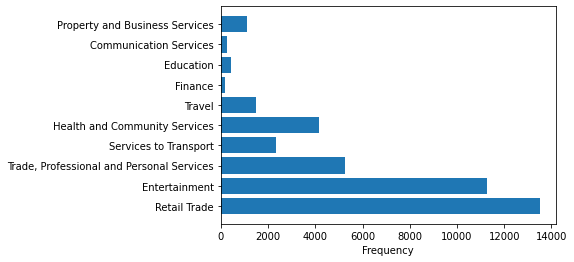

In [11]:
label_freqs = [(df_train['Category'] == label).sum() for label in labels]

plt.barh(labels, label_freqs)
plt.xlabel('Frequency')
plt.show()

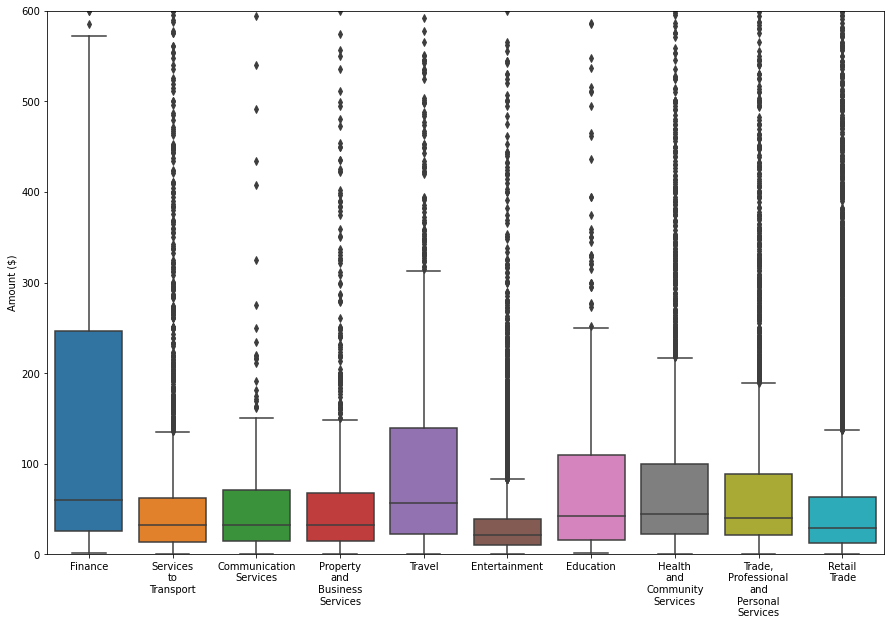

In [61]:
def fit_txt(txt):
    tokens = txt.split(' ')
    return '\n'.join(tokens)
        
fit_labels = [fit_txt(label) for label in labels]

plt.figure(figsize=(15,10))
sns.boxplot(x='Category', y='amt', data=df_train)
plt.ylim([0,600])
box_labels = [label.get_text() for label in plt.xticks()[1]]
fit_labels = [fit_txt(label) for label in box_labels]
plt.xticks(ticks=list(range(len(labels))), labels=fit_labels)
plt.xlabel('')
plt.ylabel('Amount ($)')
plt.show()

In [305]:
def google_search(q, near=None):

    params = {'q' : q}
    
    if near is not None:
        params['near'] = near
        
    q_enc = urllib.parse.urlencode(params)

    html = requests.get('https://google.com/search?' + q_enc)
    soup = BeautifulSoup(html.text)
    divs = soup.find_all("div", {"class": "BNeawe tAd8D AP7Wnd"})
    
    return [fix_entry(div.text.split('\n')[-1]) for div in divs]


def search_full(def_brand, co_brand, location):
    
    search_dict = {}
    
    for search, brand in zip(['def', 'co'], [def_brand, co_brand]):
    
        search_dict[search] = google_search(brand + ' ' + location)
    
        if not search_dict[search] or search_dict[search][0].split(' ')[0] == 'near':
            search_dict[search] = google_search(brand, near=location)
        
        search_dict[search] = list(set(search_dict[search]))
    
    return search_dict


search_full(fix_entry('NO FEAR NORTHRIDGE'), fix_entry('No Fear'), fix_entry('SALINAS CA'))

{'def': ['clothing store in salinas, california'],
 'co': ['clothing store in salinas, california', 'view all']}

In [188]:
fix_entry('DELI FOOD PLAZ11111111')

'deli food'

In [205]:
fix_entry('ANNS TAILORING & D')

'anns tailoring & d'

In [358]:
df_train_full.values

array([[58.34, '6300', 'insurance sales and underwriting', ...,
        'delta dental', 'ar', 'Finance'],
       [103.0, <NA>, <NA>, ..., 'surety solutions', 'or', 'Finance'],
       [22.44, <NA>, <NA>, ..., 'the copy stop', 'salt lake cit ut',
        'Finance'],
       ...,
       [9.95, '7399', 'business services (nec)', ..., 'propay', 'ut',
        'Finance'],
       [250.0, '6051', 'quasi cash', ..., 'cowboy finance', 'nm',
        'Finance'],
       [14.49, <NA>, <NA>, ..., 'deli grocer', 'bronx ny', 'Finance']],
      dtype=object)

In [354]:
a, b, c = np.array([1,'ok',3])

In [357]:
c

'3'

In [383]:
pd.read_csv('data/search_output/rows-10000-20000.csv')

,Amount ($),Merchant Code,Merchant Category,Default Brand,Default Brand Description,Coalesced Brand,Coalesced Brand Description,Location,Category
0,27.93,7230.0,barber or beauty shops,www.brightonbeautysupp,[],brighton beauty supply,"['beauty supply store in brooklyn, new york']",ny,Retail Trade
1,133.00,4225.0,public warehousing-farm prod refridgerat,price self storage mb,"['albuquerque stclosed ⋅ opens fri', 'near san...",price self storage,"['near san diego, ca', 'albuquerque stclosed ⋅...",san diego ca,"Trade, Professional and Personal Services"
2,25.80,NaN,NaN,real new orleans r,['cajun restaurant'],the real new orleans style restaurant,['cajun restaurant'],marble falls tx,Entertainment
3,48.15,NaN,NaN,szeto handbags and,['view all'],szeto handbags,['view all'],miami fl,Retail Trade
4,16.53,8398.0,charitable or social services organizations,unhcr,['corporate office'],bangkok thyme,['thai restaurant'],bangkok th,Entertainment
...,...,...,...,...,...,...,...,...,...
9995,37.90,5947.0,card gift novelty or souvenir shops,seashellco.com,['view all'],the seashell company,"['craft storeclosed ⋅ opens fri', 'wholesaler ...",fl,Retail Trade
9996,20.00,8041.0,chiropractors,back bone chiropractic,"['wellness center in williamson county, texas']",backbone wellness center,"['wellness center in williamson county, texas']",austin tx,Health and Community Services
9997,64.18,NaN,NaN,shaw office suppli,"['office supply store in lumberton, north caro...",shaw office supplies,"['office supply store in lumberton, north caro...",lumberton nc,Retail Trade
9998,23.50,7399.0,business services (nec),shu uemura,[],shu uemura new york ny,['view all'],montreal cd,Property and Business Services


<h1>Dataset Analysis</h1>

In [384]:
index_pairs = ['0-10000', '10000-20000', '20000-30000', '30000-40000']
dataset_files = ['data/search_output/rows-' + pair + '.csv' for pair in index_pairs]

df_train_final = pd.concat([pd.read_csv(d_file) for d_file in dataset_files], ignore_index=True, sort=False)

df_train_final

,Amount ($),Merchant Code,Merchant Category,Default Brand,Default Brand Description,Coalesced Brand,Coalesced Brand Description,Location,Category
0,58.34,6300.0,insurance sales and underwriting,delta dental of a of,"['near santa clara county, ca', 'oral surgeond...",delta dental,"['dental insurance agency in sherwood, arkansas']",ar,Finance
1,103.00,NaN,NaN,"surety solutions,","['· insurance agencysalem, orclosed ⋅ opens fr...",surety solutions,"['· insurance agencysalem, orclosed ⋅ opens fr...",or,Finance
2,22.44,NaN,NaN,the copy stop,"['copy shop in salt lake city, utah']",the copy stop,"['copy shop in salt lake city, utah']",salt lake cit ut,Finance
3,22.44,7375.0,information retrieval services,market alert inc,"['mortgage lender in plano, texas']",market alert,"['mortgage lender in plano, texas']",tx,Finance
4,66.25,NaN,NaN,pert ner perfect,[],hometown insurance partners,"['insurance agency in the woodlands, texas']",the woodlands tx,Finance
...,...,...,...,...,...,...,...,...,...
39995,100.00,NaN,NaN,allied fidelity se,[],fidelity investments,"['investment service in overland park, kansas']",ks,Finance
39996,184.78,NaN,NaN,foremost insurance,"['insurance agency in kent county, michigan']",foremost insurance,"['insurance agency in kent county, michigan']",mi,Finance
39997,9.95,7399.0,business services (nec),"propay usa propay, in",[],propay,[],ut,Finance
39998,250.00,6051.0,quasi cash,cowboy finance llc,[],cowboy finance,"['home goods store in peralta, new mexico']",nm,Finance


In [544]:
def get_desc(def_desc, co_desc):
    
    final_list = []
    for entry in co_desc + def_desc:
        if pd.notnull(entry) and entry not in final_list:
            final_list.append(entry)
    
    return 'none' if not final_list else '; '.join(final_list)

def get_message(row_data):
    
    _, _, mer_cat, def_brand, def_desc, co_brand, co_desc, _, _ = row_data
    
    msg = 'Brand 1: ' + str(co_brand) + '. '
    msg += 'Brand 2: ' + str(def_brand) + '. '
    msg += 'Merchant Category: ' + ('none' if pd.isnull(mer_cat) else str(mer_cat)) + '. '
    msg += 'Description: ' + get_desc(eval(def_desc), eval(co_desc)) + '.'
    
    return msg

def get_message_short(row_data):
    
    _, _, mer_cat, def_brand, def_desc, co_brand, co_desc, _, _ = row_data
    
    msg = 'Brand 1: ' + str(co_brand) + '.\n'
    msg += 'Brand 2: ' + str(def_brand) + '.'
    
    return msg

In [537]:
messages_short = []

for i in range(df_train_final.values.shape[0]):
    
    if i % 100 == 0:
        print(i, 'of', df_train_final.values.shape[0] - 1)
        
    messages_short.append(get_message_short(df_train_final.values[i,:]))

0 of 39999
100 of 39999
200 of 39999
300 of 39999
400 of 39999
500 of 39999
600 of 39999
700 of 39999
800 of 39999
900 of 39999
1000 of 39999
1100 of 39999
1200 of 39999
1300 of 39999
1400 of 39999
1500 of 39999
1600 of 39999
1700 of 39999
1800 of 39999
1900 of 39999
2000 of 39999
2100 of 39999
2200 of 39999
2300 of 39999
2400 of 39999
2500 of 39999
2600 of 39999
2700 of 39999
2800 of 39999
2900 of 39999
3000 of 39999
3100 of 39999
3200 of 39999
3300 of 39999
3400 of 39999
3500 of 39999
3600 of 39999
3700 of 39999
3800 of 39999
3900 of 39999
4000 of 39999
4100 of 39999
4200 of 39999
4300 of 39999
4400 of 39999
4500 of 39999
4600 of 39999
4700 of 39999
4800 of 39999
4900 of 39999
5000 of 39999
5100 of 39999
5200 of 39999
5300 of 39999
5400 of 39999
5500 of 39999
5600 of 39999
5700 of 39999
5800 of 39999
5900 of 39999
6000 of 39999
6100 of 39999
6200 of 39999
6300 of 39999
6400 of 39999
6500 of 39999
6600 of 39999
6700 of 39999
6800 of 39999
6900 of 39999
7000 of 39999
7100 of 39999
7200

In [545]:
messages = []

for i in range(df_train_final.values.shape[0]):
    
    if i % 100 == 0:
        print(i, 'of', df_train_final.values.shape[0] - 1)
        
    messages.append(get_message(df_train_final.values[i,:]))

0 of 39999
100 of 39999
200 of 39999
300 of 39999
400 of 39999
500 of 39999
600 of 39999
700 of 39999
800 of 39999
900 of 39999
1000 of 39999
1100 of 39999
1200 of 39999
1300 of 39999
1400 of 39999
1500 of 39999
1600 of 39999
1700 of 39999
1800 of 39999
1900 of 39999
2000 of 39999
2100 of 39999
2200 of 39999
2300 of 39999
2400 of 39999
2500 of 39999
2600 of 39999
2700 of 39999
2800 of 39999
2900 of 39999
3000 of 39999
3100 of 39999
3200 of 39999
3300 of 39999
3400 of 39999
3500 of 39999
3600 of 39999
3700 of 39999
3800 of 39999
3900 of 39999
4000 of 39999
4100 of 39999
4200 of 39999
4300 of 39999
4400 of 39999
4500 of 39999
4600 of 39999
4700 of 39999
4800 of 39999
4900 of 39999
5000 of 39999
5100 of 39999
5200 of 39999
5300 of 39999
5400 of 39999
5500 of 39999
5600 of 39999
5700 of 39999
5800 of 39999
5900 of 39999
6000 of 39999
6100 of 39999
6200 of 39999
6300 of 39999
6400 of 39999
6500 of 39999
6600 of 39999
6700 of 39999
6800 of 39999
6900 of 39999
7000 of 39999
7100 of 39999
7200

In [548]:
df_train_full_final = pd.DataFrame({
    'Amount ($)' : df_train_final['Amount ($)'],
    'Message' : messages,
    'Category' : df_train_final['Category']
})

df_train_full_final.to_csv('data/training_transform_full.csv', index=False)

In [546]:
df_nlp = pd.DataFrame({
    'Amount ($)' : df_train_final['Amount ($)'],
    'Message' : messages_short,
    'Label' : df_train_final['Category']
})

df_nlp['Label'] = df_nlp['Label'].map({label : i for i, label in enumerate(labels)})
df_nlp['Message'] = df_nlp['Message'].map(lambda x: x.lower())
df_nlp['Message'] = df_nlp['Message'].str.replace('[^\w\s]', '', regex=True)
df_nlp['Message'] = df_nlp['Message'].str.replace('\n', ' ')
df_nlp['Message'] = df_nlp['Message'].apply(nltk.word_tokenize)

stemmer = PorterStemmer()
 
df_nlp['Message'] = df_nlp['Message'].apply(lambda x: [stemmer.stem(y) for y in x])
df_nlp['Message'] = df_nlp['Message'].apply(lambda x: ' '.join(x))

df_nlp

,Amount ($),Message,Label
0,58.34,brand 1 delta dental brand 2 delta dental of a of,6
1,103.00,brand 1 sureti solut brand 2 sureti solut,6
2,22.44,brand 1 the copi stop brand 2 the copi stop,6
3,22.44,brand 1 market alert brand 2 market alert inc,6
4,66.25,brand 1 hometown insur partner brand 2 pert ne...,6
...,...,...,...
39995,100.00,brand 1 fidel invest brand 2 alli fidel se,6
39996,184.78,brand 1 foremost insur brand 2 foremost insur,6
39997,9.95,brand 1 propay brand 2 propay usa propay in,6
39998,250.00,brand 1 cowboy financ brand 2 cowboy financ llc,6


In [539]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
counts = count_vect.fit_transform(df_nlp['Message'])

transformer = TfidfTransformer()

counts = transformer.fit_transform(counts)

In [514]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

svd_counts = (TruncatedSVD(n_components=50).fit_transform(counts))

tsne_counts = TSNE(n_components=2, init='pca',verbose=2).fit_transform(svd_counts[:40000,:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.001s...
[t-SNE] Computed neighbors for 40000 samples in 30.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for sa

In [524]:
df_tsne = pd.DataFrame({
        'x1' : np.flip(tsne_counts[:,0]),
        'x2' : np.flip(tsne_counts[:,1]),
        'y' : np.flip(df_nlp['Label'][:40000])
})

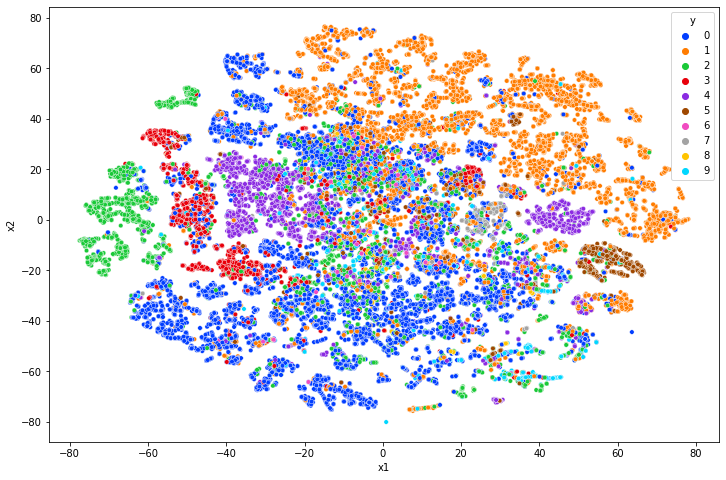

In [525]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x="x1", y="x2",
    hue="y",
    palette=sns.color_palette("bright", 10),
    data=df_tsne,
    legend="full",
    alpha=1,
    s=20
)
#plt.xlim([-200,100])
plt.show()

In [543]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts, df_nlp['Label'], test_size=0.2)

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(X_train, y_train)

predicted = model.predict(X_test)

print(np.mean(predicted == y_test))

0.663875


In [535]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predicted))

[[2475  178   15    2   12    2    0    0    0    0]
 [ 330 1962    8    1    7    2    0    0    0    0]
 [ 359   61  574    1    8    2    0    0    0    0]
 [ 341   20    1   94    1    0    0    0    0    0]
 [ 182   41    7    0  620    0    0    0    0    0]
 [ 126  113    9    0    2   58    0    0    0    0]
 [  31    1    5    0    0    0    0    0    0    0]
 [  68    7    0    0    0    0    0    0    0    0]
 [  51    4    2    0    0    0    0    0    0    0]
 [ 176   10   15    0    2    0    0    0    0   14]]


In [39]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/training_transformer_full.csv')

train, test = train_test_split(df, test_size = 0.1)

train

,Amount ($),Message,Category
28691,3.00,Brand 1: busy bee car wash. Brand 2: bird road...,Services to Transport
10665,35.00,Brand 1: smiles restored. Brand 2: smiles rest...,Health and Community Services
25013,51.00,Brand 1: pearson tire. Brand 2: pearson tire. ...,Services to Transport
5381,30.00,Brand 1: first eye care. Brand 2: first eye ca...,Health and Community Services
28139,51.75,Brand 1: familee thriftway. Brand 2: familee t...,Retail Trade
...,...,...,...
28649,50.00,Brand 1: ob gyn anesthesia pc. Brand 2: ob gyn...,Health and Community Services
4446,54.98,Brand 1: splash seafood bar and grill. Brand 2...,Entertainment
19756,8.37,Brand 1: super mex. Brand 2: super mex #. Merc...,Entertainment
21523,5.99,Brand 1: flowers kim. Brand 2: airport flowers...,Retail Trade


In [17]:
train_sample = train.sample(40000, replace=True, weights=(1 / train.groupby('Category')['Category'].transform('count')))
train_sample.groupby('Category').count()

,Amount ($),Message
Category,,
Communication Services,3997,3997
Education,4084,4084
Entertainment,4054,4054
Finance,4042,4042
Health and Community Services,3933,3933
Property and Business Services,3957,3957
Retail Trade,4042,4042
Services to Transport,4078,4078
"Trade, Professional and Personal Services",3973,3973


In [19]:
labels = list(set(df['Category']))
labels

['Services to Transport',
 'Health and Community Services',
 'Finance',
 'Communication Services',
 'Travel',
 'Trade, Professional and Personal Services',
 'Retail Trade',
 'Entertainment',
 'Property and Business Services',
 'Education']

In [40]:
df_nlp = pd.DataFrame(df)

df_nlp['Category'] = df_nlp['Category'].map({label : i for i, label in enumerate(labels)})
df_nlp['Message'] = df_nlp['Message'].map(lambda x: x.lower())
df_nlp['Message'] = df_nlp['Message'].str.replace('[^\w\s]', '', regex=True)
df_nlp['Message'] = df_nlp['Message'].str.replace('\n', ' ')
df_nlp['Message'] = df_nlp['Message'].apply(nltk.word_tokenize)

stemmer = PorterStemmer()
 
df_nlp['Message'] = df_nlp['Message'].apply(lambda x: [stemmer.stem(y) for y in x])
df_nlp['Message'] = df_nlp['Message'].apply(lambda x: ' '.join(x))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
counts = count_vect.fit_transform(df_nlp['Message'])

transformer = TfidfTransformer()

counts = transformer.fit_transform(counts)

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(counts, df_nlp['Category'], test_size=0.1)

train_df = pd.DataFrame.sparse.from_spmatrix(X_train)
train_df['y'] = y_train.reset_index(drop=True)

train_sample = train_df.sample(100000, replace=True, weights=(1 / train_df.groupby('y')['y'].transform('count')))

In [110]:
model = MultinomialNB().fit(train_sample.drop('y', axis=1), train_sample['y'])

predicted = model.predict(X_test)

print(np.mean(predicted == y_test))

0.77525


In [111]:
from sklearn.metrics import confusion_matrix

C = confusion_matrix(y_test, predicted)

print(C)

P = np.mean([1 if np.sum(C[i, :]) == 0 else  C[i,i] / np.sum(C[i,:]) for i in range(C.shape[0])])
R = np.mean([1 if np.sum(C[:, i]) == 0 else C[i,i] / np.sum(C[:, i]) for i in range(C.shape[0])])

F = (P * R) / (P + R)

print(F)

[[212   3   1   1   9   4  10   4   2   2]
 [  4 378   3   0   2   3   5   4   4  10]
 [  1   0  20   0   0   0   2   0   1   0]
 [  1   0   0  14   0   0   0   1   2   1]
 [  4   3   4   4 112   3   3   4   0   5]
 [ 15  11  12  11   9 365  37  13  23  13]
 [ 93  16  21  27  39  65 965  64  40  32]
 [ 13  20   7   7  46  14  58 935  15  19]
 [  1   3   2   5   6   9   4   4  65   2]
 [  1   4   1   0   1   0   4   0   2  35]]
0.3305288760659186


In [116]:
import torch

t = torch.Tensor([[10,20,30], [4,5,6], [-1,8,9]])

t.argmax(dim=0)

tensor([0, 0, 0])

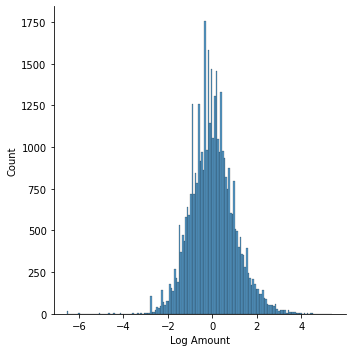

In [22]:
df = pd.read_csv('data/training_transformer_full.csv')

df['Log Amount'] = np.log(df['Amount ($)'])

df['Log Amount'] = (df['Log Amount'] - df['Log Amount'].mean()) / (df['Log Amount'].std())

sns.displot(df['Log Amount'])
plt.show()

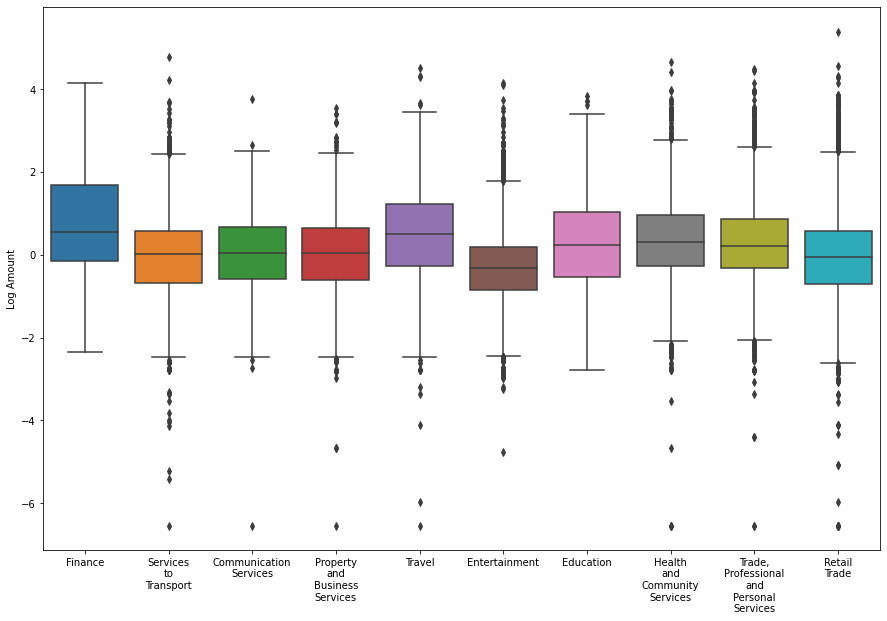

In [23]:
def fit_txt(txt):
    tokens = txt.split(' ')
    return '\n'.join(tokens)

labels = list(set(df['Category']))
labels
        
fit_labels = [fit_txt(label) for label in labels]

plt.figure(figsize=(15,10))
sns.boxplot(x='Category', y='Log Amount', data=df)
#plt.ylim([0,600])
box_labels = [label.get_text() for label in plt.xticks()[1]]
fit_labels = [fit_txt(label) for label in box_labels]
plt.xticks(ticks=list(range(len(labels))), labels=fit_labels)
plt.xlabel('')
plt.ylabel('Log Amount')
plt.show()

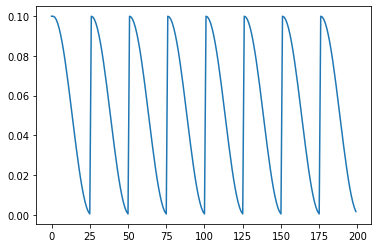

In [50]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn as nn
import torch

class Model(nn.Module):

    def __init__(self):

        super(Model, self).__init__()
        
        self.fc = nn.Linear(10,1)


    def forward(self, x):

        return self.fc(x)

model = Model()

optimizer = optim.Adam(params=model.parameters(), lr=0.1)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1)

lrs = []

for epoch in range(200):
    
    for i in range(1):
        
        lrs.append(scheduler.get_last_lr())
        scheduler.step(epoch + i / 10)
        

plt.plot(lrs)
plt.show()

In [67]:
n_checkpoints = 10
iters = 121

ipc = iters // n_checkpoints

print([i for i in range(iters) if i % ipc == 0 and i != 0 and i != iters - 1])

[12, 24, 36, 48, 60, 72, 84, 96, 108]


In [145]:
df = pd.read_csv('data/human_labels/seed1-0-200.csv')

In [147]:
np.mean(df['label'] == df['prediction'])

0.88

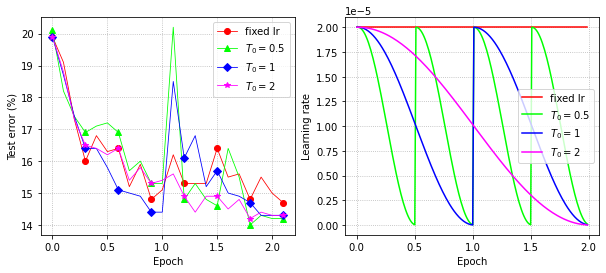

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn as nn
import torch

df = pd.read_csv('deep_learning/saved_results/xlnet_cosine.csv').sort_values(by=['settings'])

def get_T_0(settings):
    try:
        s_list = settings.split('T_0-')
        s_str = ''.join(s_list[1:])
        s_list = s_str.split('--')
        T_0 = float(s_list[0])
    except:
        T_0 = 0
    return T_0

def get_seed(settings):
    s_list = settings.split('seed-')
    return int(s_list[1])

df['T_0'] = df['settings'].apply(get_T_0)
df['seed'] = df['settings'].apply(get_seed)

def get_errors(T_0):
    acc_f1s = eval(df[(df['T_0'] == T_0) & (df['seed'] == 1)]['checkpoint_accs'].iloc[0])
    return np.array([1 - x for x, _ in acc_f1s]) * 100
    

errors = {label : get_errors(T_0) for T_0, label in 
                              zip([0, 0.5, 1, 2], ['fixed lr', r'$T_{0} = 0.5$', r'$T_{0} = 1$', r'$T_{0} = 2$'])}

epochs = np.array(list(range(len(errors['fixed lr'])))) / 10

markers = ['o', '^', 'D', '*']
colors = [(1,0,0), (0,1,0), (0,0,1), (1,0,1)]

fig, ax = plt.subplots(1, 2, figsize=(10,4))

for i, label in enumerate(errors):
    ax[0].plot(epochs, errors[label], label=label, marker=markers[i], markevery=3, color=colors[i], linewidth=0.8)
ax[0].legend()
ax[0].grid(linestyle=':')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Test error (%)')


def get_lrs(T_0):

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.fc = nn.Linear(10,1)
        def forward(self, x):
            return self.fc(x)

    model = Model()
    optimizer = optim.Adam(params=model.parameters(), lr=2e-5)
    
    try:
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=int(100 * T_0), T_mult=1)
    except:
        return [2e-5] * 200

    lrs = []

    for i in range(200):
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step(i)
    
    return lrs

epochs = np.array(list(range(200))) / 100

for i, (T_0, label) in enumerate(zip([0, 0.5, 1, 2], errors)):
    ax[1].plot(epochs, get_lrs(T_0), label=label, color=colors[i])
ax[1].legend(loc='center right')
ax[1].grid(linestyle=':')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Learning rate')
plt.show()

In [9]:
df['acc'] = df['max_acc'].apply(lambda x: eval(x)[0])
df['f1'] = df['max_acc'].apply(lambda x: eval(x)[1])

def round1(num):
    return str(round(10 * num) / 10)

def get_metric(T_0, index=0):
    
    metric = 'acc' if index == 0 else 'f1'
    mean = df.groupby('T_0')[metric].mean().loc[T_0]
    std = df.groupby('T_0')[metric].std().loc[T_0]
    return round1(100 * mean) + ' ± ' + round1(100 * std)

print(*[get_metric(T_0, index=1) for T_0 in [0, 0.5, 1, 2]], sep='\n')



74.1 ± 2.9
76.6 ± 3.2
76.3 ± 3.6
77.0 ± 3.3


In [235]:
df.groupby('T_0')['acc'].mean().loc[0.5]

0.8786666666666667

In [ ]:
df.groupby('T_0').mean()